---
title: "analytical confidence interval"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.stats import norm, ttest_ind, t
import scipy
# %matplotlib widget

We wish to compute the confidence interval for the mean height of 7-year-old boys, for a sample of size $N$.

We will start our journey with a refresher of the Central Limit Theorem (CLT).

## CLT

The Central Limit Theorem states that the sampling distribution of the sample mean

$$
\bar{X} = \frac{1}{N} \sum_{i=1}^{N} X_i
$$

approaches a normal distribution as the sample size $N$ increases, regardless of the shape of the population distribution. This normal distribution can be expressed as:

$$
\bar{X} \sim N\left(\mu, \frac{\sigma^2}{N}\right),
$$

where $\mu$ and $\sigma^2$ are the population mean and variance, respectively. When talking about samples, we use $\bar{x}$ and $s^2$ to denote the sample mean and variance.

Let's visualize this. The graph below shows how the sample size $N$ affects the sampling distribution of the sample mean $\bar{X}$. The higher the sample size, the more concentrated the distribution becomes around the population mean $\mu$. If we take $N$ to be infinity, the sampling distribution of the sample mean becomes a delta function at $\mu$, and we will know the exact value of the population mean.


In [2]:
#| code-summary: "load data"
df_boys = pd.read_csv('../archive/data/height/boys_height_stats.csv', index_col=0)
mu_boys = df_boys.loc[7.0, 'mu']
sigma_boys = df_boys.loc[7.0, 'sigma']

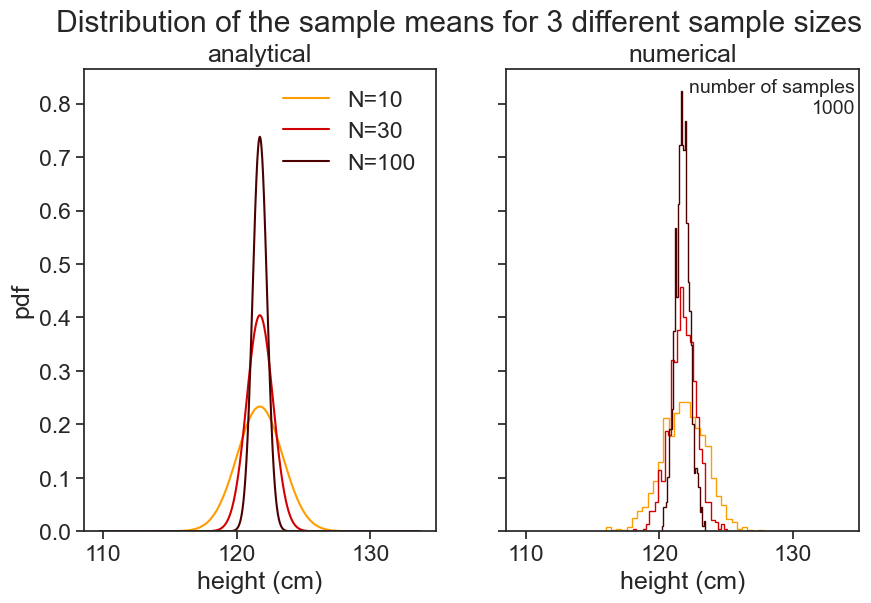

In [4]:
#| code-summary: "plot pdfs as function of sample size"
fig, ax = plt.subplots(1,2, figsize=(10, 6), sharex=True, sharey=True)

height_list = np.arange(mu_boys-12, mu_boys+12, 0.01)
N_list = [10, 30, 100]
alpha_list = [0.4, 0.6, 1.0]

colors = plt.cm.hot([0.6, 0.3, 0.1])

N_samples = 1000
np.random.seed(628)
mean_list_10 = []
mean_list_30 = []
mean_list_100 = []
for i in range(N_samples):
    mean_list_10.append(np.mean(norm.rvs(size=10, loc=mu_boys, scale=sigma_boys)))
    mean_list_30.append(np.mean(norm.rvs(size=30, loc=mu_boys, scale=sigma_boys)))
    mean_list_100.append(np.mean(norm.rvs(size=100, loc=mu_boys, scale=sigma_boys)))

alpha = 0.05

# z_alpha_over_two = norm(loc=mu_boys, scale=SE).ppf(1 - alpha / 2)
# z_alpha_over_two = np.round(z_alpha_over_two, 2)

for i,N in enumerate(N_list):
    SE = sigma_boys / np.sqrt(N)
    ax[0].plot(height_list, norm(loc=mu_boys, scale=SE).pdf(height_list),
            color=colors[i], label=f"N={N}")
    
ax[1].hist(mean_list_10, bins=30, density=True, color=colors[0], label="N=10", align='mid', histtype='step')
ax[1].hist(mean_list_30, bins=30, density=True, color=colors[1], label="N=10", align='mid', histtype='step')
ax[1].hist(mean_list_100, bins=30, density=True, color=colors[2], label="N=10", align='mid', histtype='step')

ax[1].text(0.99, 0.98, "number of samples\n1000", ha='right', va='top', transform=ax[1].transAxes, fontsize=14)

ax[0].legend(frameon=False)
ax[0].set(xlabel="height (cm)",
       ylabel="pdf",
       title="analytical"
       )
ax[1].set(xlabel="height (cm)",
          title="numerical"
          )
# title that hovers over both subplots
fig.suptitle(f"Distribution of the sample means for 3 different sample sizes");

## confidence interval 1
Let's use now the sample size $N=30$. The confidence interval for a significance level $\alpha=0.05$ is the interval that leaves $\alpha/2$ of the pdf area in each tail of the distribution.

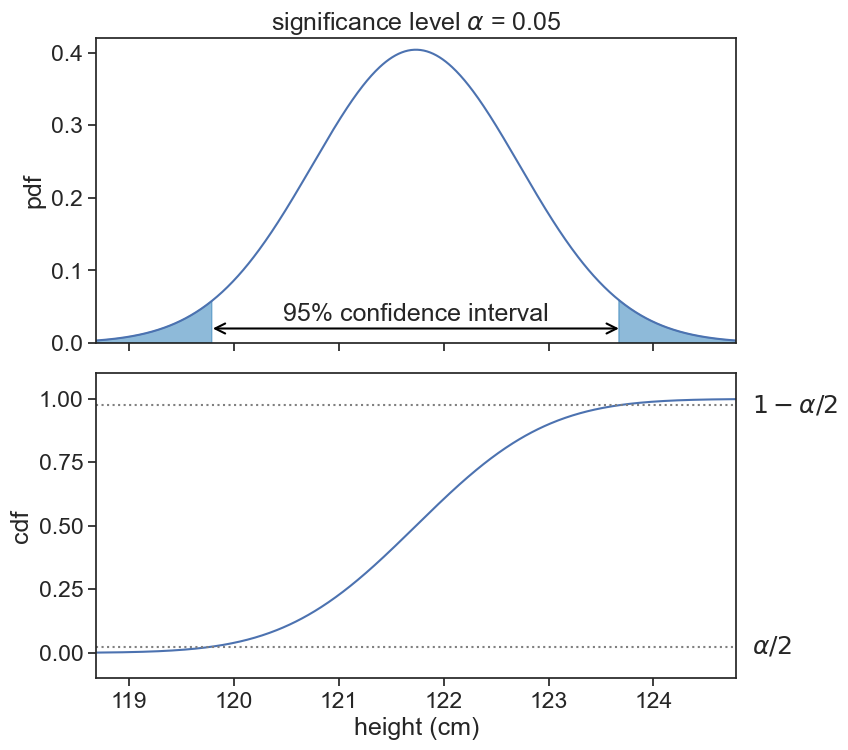

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.0, hspace=0.1)
N = 30
SE = sigma_boys / np.sqrt(N)

h_min = np.round(norm(loc=mu_boys, scale=SE).ppf(0.001), 2)
h_max = np.round(norm(loc=mu_boys, scale=SE).ppf(0.999), 2)
height_list = np.arange(h_min, h_max, 0.01)

alpha = 0.05
z_alpha_over_two_hi = np.round(norm(loc=mu_boys, scale=SE).ppf(1 - alpha / 2), 2)
z_alpha_over_two_lo = np.round(norm(loc=mu_boys, scale=SE).ppf(alpha / 2), 2)


ax[0].plot(height_list, norm(loc=mu_boys, scale=SE).pdf(height_list))
ax[1].plot(height_list, norm(loc=mu_boys, scale=SE).cdf(height_list))

ax[0].fill_between(height_list, norm(loc=mu_boys, scale=SE).pdf(height_list),
                   where=((height_list > z_alpha_over_two_hi) | (height_list < z_alpha_over_two_lo)),
                   color='tab:blue', alpha=0.5,
                   label='rejection region')

ax[0].annotate(f"",
               xy=(z_alpha_over_two_hi, 0.02),
               xytext=(z_alpha_over_two_lo, 0.02),
               arrowprops=dict(arrowstyle="<->", lw=1.5, color='black', shrinkA=0.0, shrinkB=0.0),
               )
ax[1].text(h_max+0.15, norm(loc=mu_boys, scale=SE).cdf(z_alpha_over_two_lo), r"$\alpha/2$",
           ha="left", va="center")
ax[1].text(h_max+0.15, norm(loc=mu_boys, scale=SE).cdf(z_alpha_over_two_hi), r"$1-\alpha/2$",
           ha="left", va="center")
ax[1].axhline(alpha/2, color='gray', linestyle=':')
ax[1].axhline(1-alpha/2, color='gray', linestyle=':')
ax[0].text(mu_boys, 0.03, "95% confidence interval", ha="center")
ax[0].set(ylim=(0, 0.42),
          ylabel="pdf",
          title=r"significance level $\alpha$ = 0.05",
          )
ax[1].set(ylim=(-0.1, 1.1),
          xlim=(h_min, h_max),
          ylabel="cdf",
          xlabel="height (cm)",
          );

That's it. That's the whole story.

## confidence interval 2

The rest is repackaging the above in a slightly different way.
Instead of finding the top and bottom of the confidence interval according to the cdf of a normal distribution of mean $\mu$ and variance $\sigma^2/N$, we first standardize this distribution to a standard normal distribution $Z \sim N(0,1)$, compute the confidence interval for $Z$, and then transform it back to the original distribution.

If the distribution of the sample mean $\bar{X}$

$$
\bar{X} \sim N\left(\mu, \frac{\sigma^2}{N}\right),
$$

then the standardized variable $Z$ is defined as:

$$
Z = \frac{\bar{x} - \mu}{\sigma/\sqrt{N}} \sim N(0,1).
$$

Why is this useful? Because we usually use the same significance level $\alpha$ for all confidence intervals, and we can compute the confidence interval for $Z$ once and use it for all confidence intervals. For $Z \sim N(0,1)$ and $\alpha=0.05$, the top and bottom of the confidence interval are $Z_{\alpha/2}=\pm 1.96$. Now we only have to invert the expression above to get the confidence interval for $\bar{X}$:

$$
X_{1,2} = \mu \pm Z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{N}}.
$$

The very last thing we have to account for is the fact that we don't know the population statistics $\mu$ and $\sigma^2$. Instead, we have to use the sample statistics $\bar{x}$ and $s^2$. Furthermore, we have to use the t-distribution instead of the normal distribution, because we are estimating the population variance from the sample variance. The t-distribution has a shape similar to the normal distribution, but it has heavier tails, which accounts for the additional uncertainty introduced by estimating the population variance.
Thus, we replace $\mu$ with $\bar{x}$ and $\sigma^2$ with $s^2$, and we use the t-distribution with $N-1$ degrees of freedom.
This gives us the final expression for the confidence interval:

$$
X_{1,2} = \bar{x} \pm t^*_{N-1} \cdot \frac{s}{\sqrt{N}},
$$

where $t^*_{N-1}$ is the critical value from the t-distribution with $N-1$ degrees of freedom.


## the solution

Let's say I measured the heights of 30 7-year-old boys, and this is the data I got:

In [ ]:
N = 30
np.random.seed(271)
sample = norm.rvs(size=N, loc=mu_boys, scale=sigma_boys)
print(f"Sample mean: {np.mean(sample):.2f} cm")
print(sample)

Sample mean: 122.60 cm
[114.15972134 128.21581493 122.9864136  117.94247325 132.11013925
 118.69131645 123.67695468 112.03152008 121.59853424 114.8629358
 121.90458112 115.68839748 127.18043069 118.33193499 125.28525617
 124.5287395  120.72706375 113.10575734 132.229147   129.16820684
 125.94682095 126.08299475 125.95056303 125.6858065  115.07854075
 124.93539918 125.12886271 126.91366971 120.88030405 127.04777082]


Using the formula for the confidence interval we get:

In [ ]:
alpha = 0.05
z_crit = scipy.stats.t.isf(alpha/2, N-1)
CI = z_crit * sample.std(ddof=1) / np.sqrt(N)
CI_low = np.round(sample.mean() - CI, 2)
CI_high = np.round(sample.mean() + CI, 2)
print(f"Sample mean: {np.mean(sample):.2f} cm")
print("The 95% confidence interval is [{}, {}] cm".format(CI_low, CI_high))
print(f"The true population mean is {mu_boys:.2f} cm")

Sample mean: 122.60 cm
The 95% confidence interval is [120.54, 124.67] cm
The true population mean is 121.74 cm


## a few points to stress

It is worth commenting on a few points:

* If we were to sample a great many number of samples of size $N=30$, and compute the confidence interval for each sample, then approximately 95% of these intervals would contain the true population mean $\mu$.
* It is not true that the probability that the true population mean $\mu$ is in the confidence interval is 95%. The true population mean is either in the interval or not, and it does not have a probability associated with it. The 95% confidence level refers to the long-run frequency of intervals containing the true population mean if we were to repeat the sampling process many times. This is the common *frequentist* interpretation of confidence intervals.
* If you want to talk about confidence interval in the *Bayesian* framework, then first we would have to assign a prior distribution to the population mean $\mu$, and then we would compute the posterior distribution of $\mu$ given the data. The credible interval is then the interval that contains 95% of the posterior distribution of $\mu$.
* To sum up the difference between the frequentist and Bayesian interpretations of confidence intervals:

  - Frequentist CI: "I am 95% confident in the method" (long-run frequency).
  - Bayesian credible interval: "There is a 95% probability that μ lies in this interval" (degree of belief).
